# CSCA 5632 Mini Project: BBC News Classification

In [129]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt_tab')
import re

# we can also work with wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [94]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Exploratory Data Analysis (EDA)

In [95]:
df_train = pd.read_csv('./data/news/BBC News Train.csv')
df_test = pd.read_csv('./data/news/BBC News Test.csv')

### Data inspection

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [97]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


Train dataset has 1490 data points with article ID, article text and category labels. Test dataset has 735 entries with article ID and article text, but no labels. Both train and test data have only non-null values, so we do not need to drop any entries based on null values.

### Drop Duplicates

Although we did not have to drop any null values, we should still check for duplicates in train data.

In [98]:
df_train = df_train.drop_duplicates(subset=['Text'])
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


After dropping duplicates, we are left with 1440 entries (50 dropped).

### Check Class Imbalance

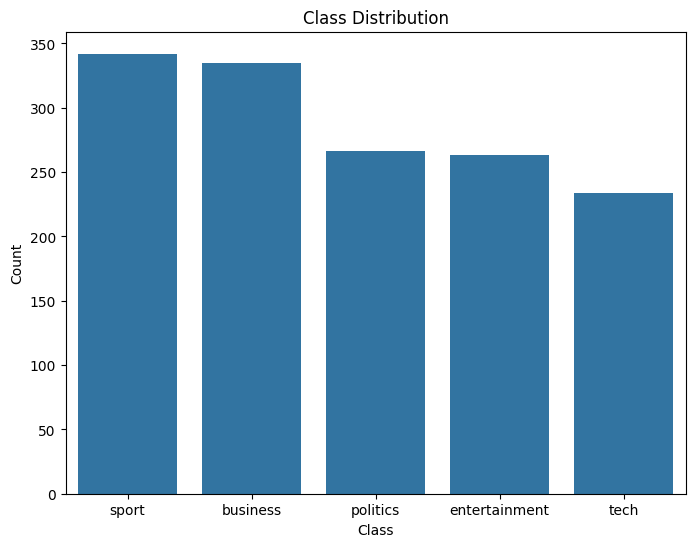

In [99]:
class_counts = df_train['Category'].value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

There is a slight imbalance in labels towards sports and business articles, but it seems each label has decent representation.

### Text Cleaning

Next, we must perform preprocessing specific to the texts. Below is an example of an unprocessed text.

#### Before cleaning:

In [100]:
df_train.iloc[0]['Text']

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

Some low hanging fruits in cleaning the texts involve ensuring that they are all in lower case and stripping away punctuations, but I found an exhaustive list of text cleaning in a related Kaggle Notebook [[1](#[1]-https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels/notebook)], some of which we will consider:

1. Ensure letters are all lower case
2. Remove punctuation
3. Remove extra whitespaces
4. Remove stop words
5. Reduce words to stems

We want to remove stop words such as the definite and indefinite articles "the" and "a/an", because even though they are some of the most frequent words in a body of text, they do not provide much context clues. Furthermore, we want to reduce words to its stems because we could get stronger signals for topics if variations of the same words were reduced to a common form.

In [112]:
# ensure lower case
df_train['Text'] = df_train['Text'].str.lower()
df_test['Text'] = df_test['Text'].str.lower()

# remove punctuation
df_train['Text'] = df_train['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))
df_test['Text'] = df_test['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

# remove stop words
stop_words = nltk.corpus.stopwords.words('english')
df_train['Text'] = df_train['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))
df_test['Text'] = df_test['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

# remove extra white spaces
df_train['Text'] = df_train['Text'].apply(lambda doc: re.sub(' +', ' ', doc))
df_test['Text'] = df_test['Text'].apply(lambda doc: re.sub(' +', ' ', doc))

# stemming
porter_stemmer = PorterStemmer()
df_train['Text'] = df_train['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
df_train['Text'] = df_train['Text'].apply(lambda words: ' '.join(words))
df_test['Text'] = df_test['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
df_test['Text'] = df_test['Text'].apply(lambda words: ' '.join(words))


In [113]:
df_train['Text']

0       worldcom exboss launch defenc lawyer defend fo...
1       german busi confid slide german busi confid fe...
2       bbc poll indic econom gloom citizen major nati...
3       lifestyl govern mobil choic faster better funk...
4       enron boss 168m payout eighteen former enron d...
                              ...                        
1485    doubl evict big brother model capric holbi cit...
1486    dj doubl act revamp chart show dj duo jk joel ...
1487    weak dollar hit reuter revenu media group reut...
1488    appl ipod famili expand market appl expand ipo...
1489    santi worm make unwelcom visit thousand websit...
Name: Text, Length: 1440, dtype: object

In [114]:
df_test['Text']

0      qpr keeper day head preston queen park ranger ...
1      softwar watch work softwar monitor everi keyst...
2      arci injuri add ireland woe gordon arci rule i...
3      india relianc famili feud heat ongo public spa...
4      boro suffer morrison injuri blow middlesbrough...
                             ...                        
730    eu probe alitalia state aid european commiss o...
731    u2 play grammi award show irish rock band u2 p...
732    sport bet rule spotlight group mp peer call ti...
733    alfa romeo get gm engin fiat stop make sixcyli...
734    citizenship event 18 tout citizenship ceremoni...
Name: Text, Length: 735, dtype: object

#### After Cleaning:

In [115]:
df_train.iloc[0]['Text']

'worldcom exboss launch defenc lawyer defend former worldcom chief berni ebber batteri fraud charg call compani whistleblow first wit cynthia cooper worldcom exhead intern account alert director irregular account practic us telecom giant 2002 warn led collap firm follow discoveri 11bn 57bn account fraud mr ebber plead guilti charg fraud conspiraci prosecut lawyer argu mr ebber orchestr seri account trick worldcom order employ hide expen inflat revenu meet wall street earn estim ms cooper run consult busi told juri new york wednesday extern auditor arthur andersen approv worldcom account earli 2001 2002 said andersen given green light procedur practic use worldcom mr ebber lawyer said unawar fraud argu auditor alert problem ms cooper also said sharehold meet mr ebber often pass technic question compani financ chief give brief answer prosecut star wit former worldcom financ chief scott sullivan said mr ebber order account adjust firm tell hit book howev ms cooper said mr sullivan mention

## Model Training

### NMF

In [137]:
unique_labels = sorted(list(df_train['Category'].unique()))
print(unique_labels)

# # helper function from CSCA 5632 Week 2 Lab
def label_permute_compare(ytdf,yp,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    permutations = list(itertools.permutations(range(n)))
    
#     print(yp)
#     print(np.take((0,1,2,3,'hello world'), yp))
    
    max_acc = float('-inf')
    permutation_ = None
    prediction_ = None
    
    for permutation in permutations:
        cluster_to_index = np.take(permutation, yp)
        prediction = np.take(unique_labels, cluster_to_index)
        
        acc = sum(ytdf.Category == prediction)/ytdf.Category.shape[0]
        if acc > max_acc:
            max_acc = acc
            permutation_ = permutation
            prediction_ = prediction

    return permutation_, max_acc

['business', 'entertainment', 'politics', 'sport', 'tech']


In [157]:
# try a set of parameters

In [ ]:
# tune parameters
for min_df in [5, 7, 9]:
    for max_df in [.8, .9, .95]:
        for max_features in [500, 1000, 1500]:
            tfidf = TfidfVectorizer(min_df = min_df,   
                                    max_df = max_df,
                                    max_features = max_features)
            tfidf_train = tfidf.fit_transform(df_train['Text'])
            
            nmf = NMF(n_components=5,
                      init='nndsvda', 
                      solver = 'mu',
                      beta_loss = 'kullback-leibler',
                      random_state = 0)
            nmf_train = nmf.fit_transform(tfidf_train)
            yp = np.argmax(nmf_train, axis=1)
            print(yp)
            print(len(yp), min_df, max_df)
            print(label_permute_compare(df_train, yp))


## References

##### [1] https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels/notebook
##### [2] https://www.kaggle.com/code/dazhengzhu/bbc-news-classification
##### [3] https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
##### [4] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html